In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import time
from utils import *

from rec import Rec
from types import SimpleNamespace   

import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")

%matplotlib inline

## Sizes and propagation settings

In [2]:
n = 1024  # data size in each dimension
npsi = n + n // 4  # object size in each dimension
pad = n // 16  # pad for the reconstructed probe
nq = n + 2 * pad  # probe size
ex = 8  # extra padding for shifts
npatch = nq + 2 * ex  # patch size for shifts
npos = 16  # total number of positions

voxelsize = 2e-8  # [m]
distance = 0.0043  # [m]
energy = 33.35  # [keV]
wavelength = 1.24e-09 / energy  # [m]
eps = 1e-8  # avoid division by 0 in computations
npos_chunk = 4

## Load object, probe, and 16 positions

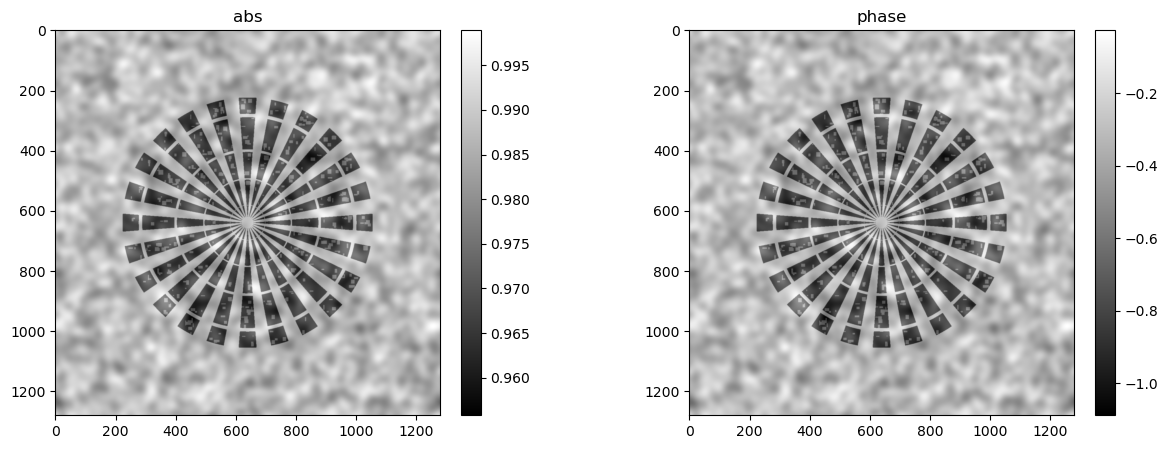

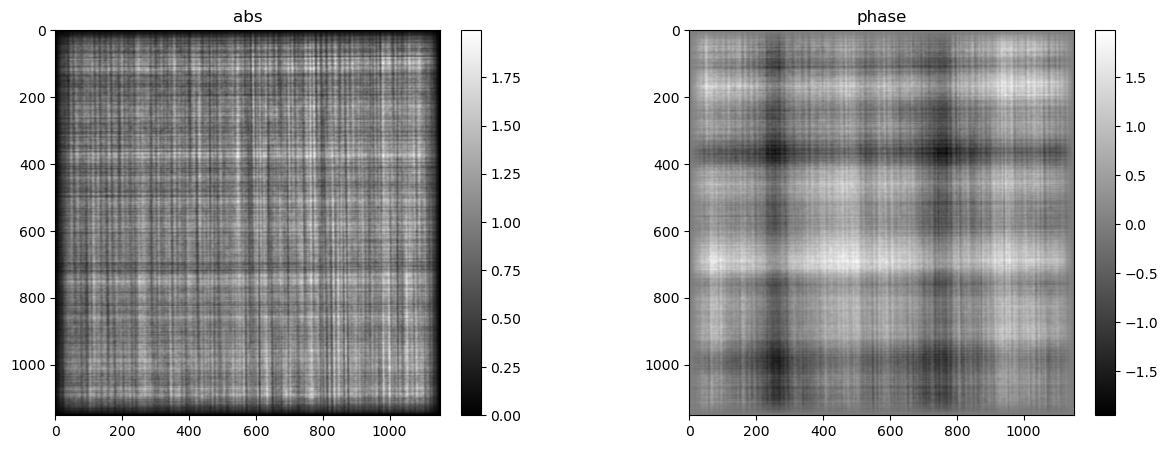

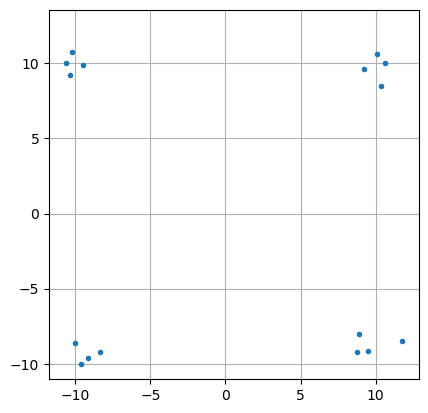

In [3]:
psi = np.load("psi.npy")
q = np.load("q.npy")
pos = np.load("pos.npy")

mshow_polar(psi)
mshow_polar(q)
mplot_positions(pos)

In [4]:

args = SimpleNamespace()

args.ngpus = 4
args.npsi = npsi
args.nq = nq
args.npatch = npatch
args.n = n
args.npos = npos
args.nchunk = 4
args.pad = pad
args.ex = 8
args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.eps = 1e-8
args.rho = np.array([1,2,0.1])

cl_rec = Rec(args)



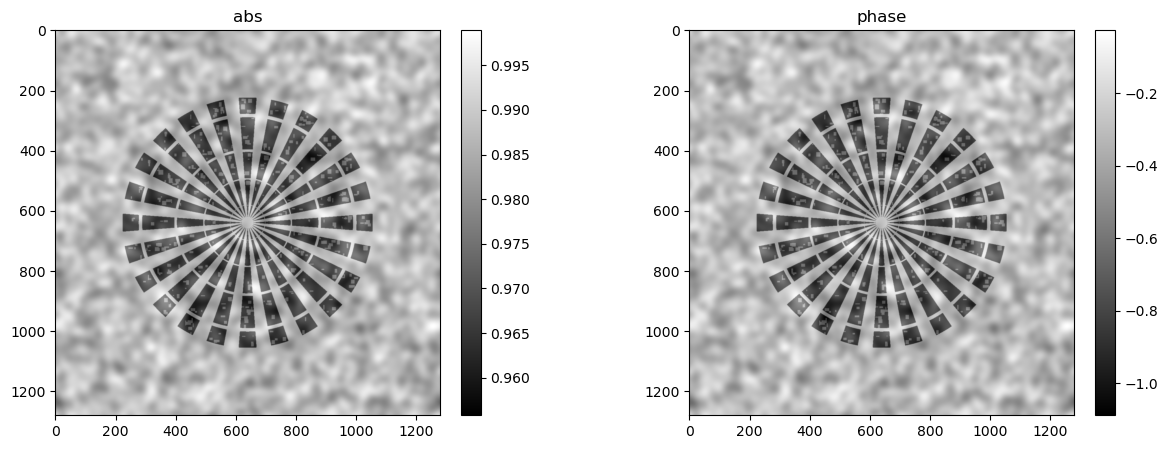

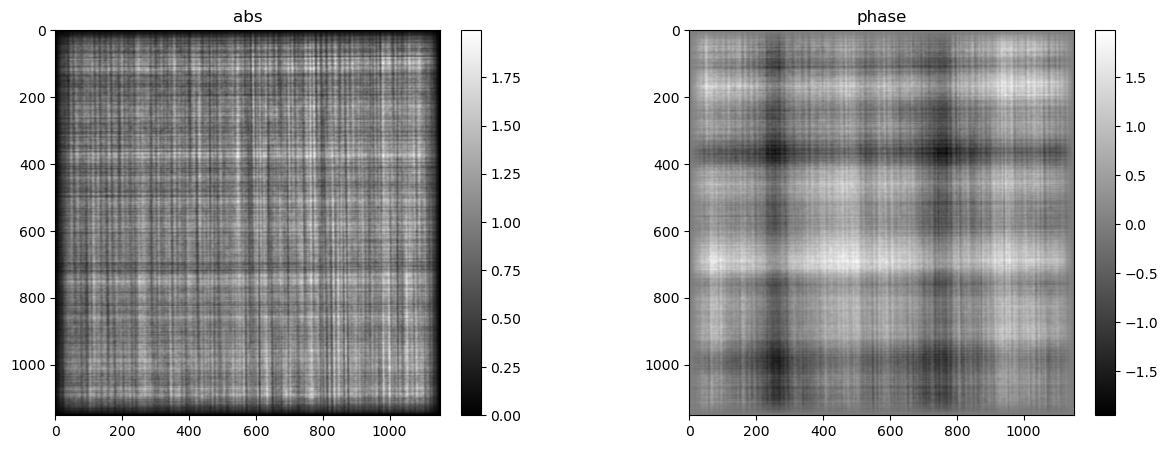

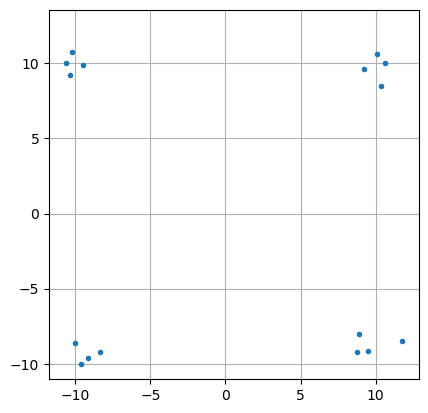

In [5]:
psi = np.load("psi.npy")
q = np.load("q.npy")
pos = np.load("pos.npy")

mshow_polar(psi)
mshow_polar(q)
mplot_positions(pos)

### Introduce position error

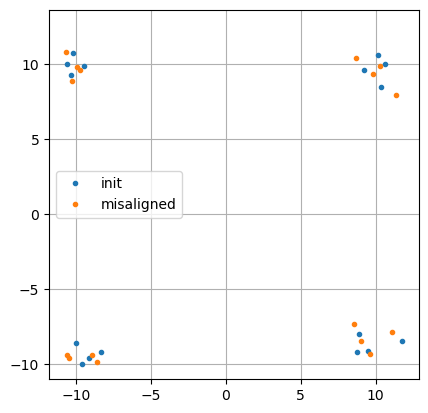

In [6]:
np.random.seed(100)
pos_init = pos + (np.random.random(pos.shape) - 0.5) * 2

plt.plot(pos[:, 1], pos[:, 0], ".", label="init")
plt.plot(pos_init[:, 1], pos_init[:, 0], ".", label="misaligned")

plt.legend()
plt.axis("square")
plt.grid()

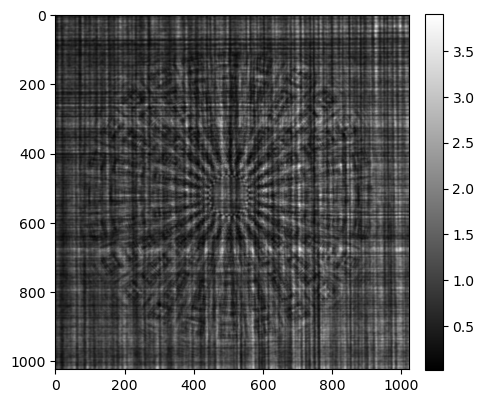

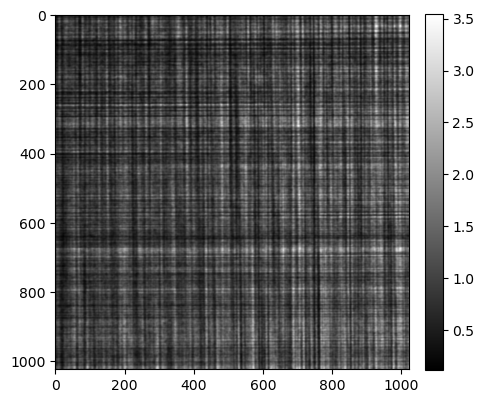

In [7]:
ri = np.floor(pos).astype("int32")
r = (pos - ri).astype('float32')

data = np.abs(cl_rec.fwd(ri,r,psi,q)) ** 2

dref = np.abs(cl_rec.fwd(ri,r,psi*0+1,q)) ** 2
dref = dref[0]

mshow(data[0])
mshow(dref)

### Initial guess for the object calculated with the Paganin method

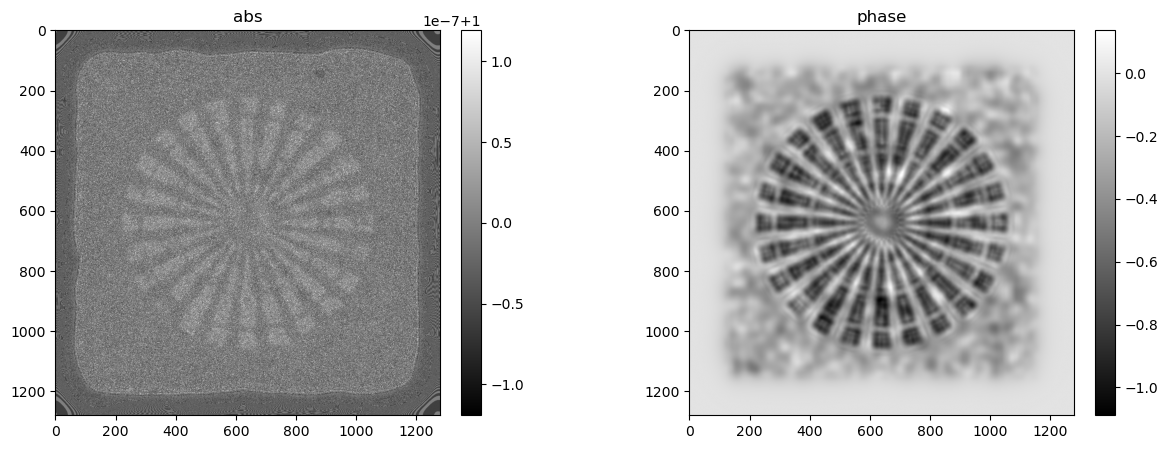

In [8]:
def Paganin(data, wavelength, voxelsize, delta_beta, alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2 + fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    return phase


def rec_init(rdata, ri):
    recMultiPaganin = cp.zeros([npsi, npsi], dtype="float32")
    recMultiPaganinr = cp.zeros(
        [npsi, npsi], dtype="float32"
    )  # to compensate for overlap
    for j in range(npos):
        r = cp.array(rdata[j])
        pos = r * 0 + 1  # to compensate for overlap
        rpsi = cp.ones([npsi, npsi], dtype="float32")
        rrpsi = cp.ones([npsi, npsi], dtype="float32")
        stx = npsi // 2 - ri[j, 1] - n // 2
        endx = stx + n
        sty = npsi // 2 - ri[j, 0] - n // 2
        endy = sty + n
        rpsi[sty:endy, stx:endx] = r
        rrpsi[sty:endy, stx:endx] = pos
        rpsi = Paganin(rpsi, wavelength, voxelsize, 24.05, 1e-6)
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi

    recMultiPaganinr[np.abs(recMultiPaganinr) < 5e-2] = 1
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = np.exp(1j * recMultiPaganin)
    return recMultiPaganin


ri = cp.round(pos_init).astype("int32")
rdata = data / (dref + 1e-9)
psi_init = rec_init(rdata, ri)
mshow_polar(psi_init)

#### Initial guess for the probe calculated by backpropagating the square root of the reference image
#### Smooth the probe borders for stability

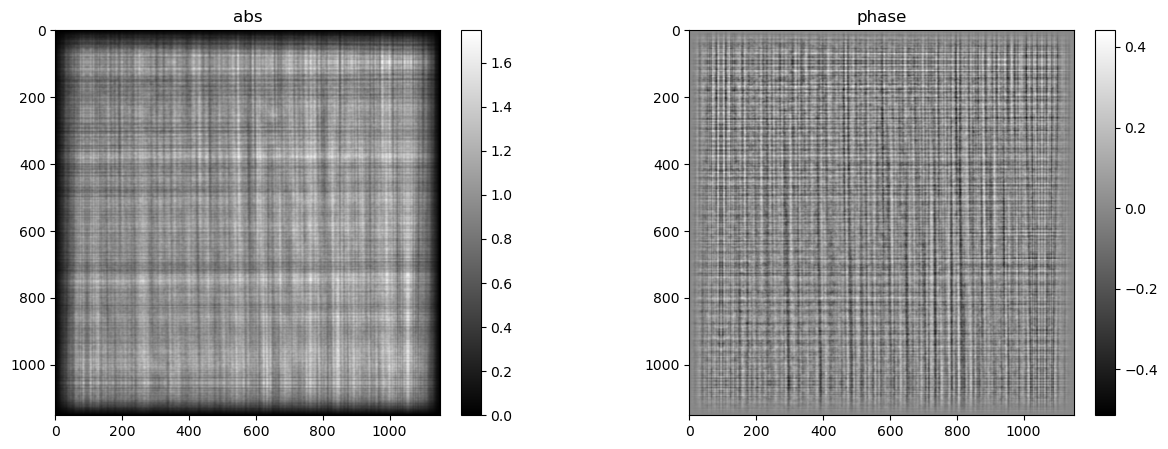

In [9]:
q_init = cp.array(cl_rec.DT(np.sqrt(dref[np.newaxis]))[0])

ppad = 3 * pad // 2
q_init = np.pad(
    q_init[ppad : nq - ppad, ppad : nq - ppad],
    ((ppad, ppad), (ppad, ppad)),
    "symmetric",
)
v = cp.ones(nq, dtype="float32")
vv = cp.sin(cp.linspace(0, cp.pi / 2, ppad))
v[:ppad] = vv
v[nq - ppad :] = vv[::-1]
v = cp.outer(v, v)
q_init = cp.abs(q_init * v) * cp.exp(1j * cp.angle(q_init) * v)

mshow_polar(q_init)

0) err=1.37142e+05
1) err=3.27964e+04
2) err=1.60554e+04
3) err=9.21459e+03
4) err=6.86950e+03
5) err=4.23817e+03
6) err=3.10387e+03
7) err=2.56205e+03
8) err=2.27074e+03
9) err=2.08826e+03
10) err=1.89888e+03
11) err=1.71826e+03
12) err=1.53338e+03
13) err=1.35268e+03
14) err=1.22098e+03
15) err=1.13027e+03
16) err=1.03907e+03
17) err=9.56989e+02
18) err=8.88852e+02
19) err=8.19602e+02
20) err=7.64151e+02
21) err=7.06914e+02
22) err=6.62898e+02
23) err=6.20947e+02
24) err=5.84934e+02
25) err=5.50832e+02
26) err=5.22510e+02
27) err=4.91346e+02
28) err=4.65190e+02
29) err=4.41228e+02
30) err=4.19703e+02
31) err=4.01472e+02
32) err=3.81812e+02
33) err=3.65220e+02
34) err=3.47995e+02
35) err=3.33139e+02
36) err=3.19173e+02
37) err=3.07404e+02
38) err=2.94271e+02
39) err=2.83576e+02
40) err=2.71559e+02
41) err=2.62383e+02
42) err=2.52511e+02
43) err=2.44247e+02
44) err=2.35646e+02
45) err=2.27797e+02
46) err=2.20065e+02
47) err=2.13135e+02
48) err=2.06649e+02
49) err=2.00204e+02
50) err=1.

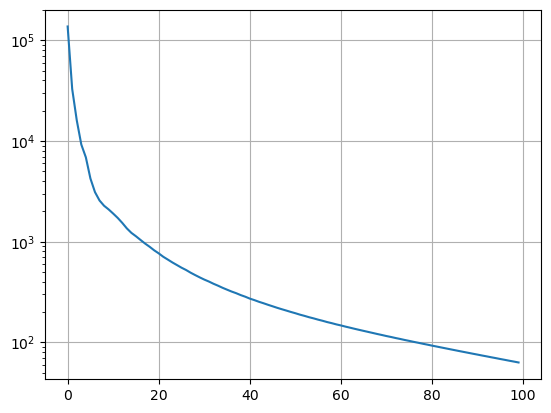

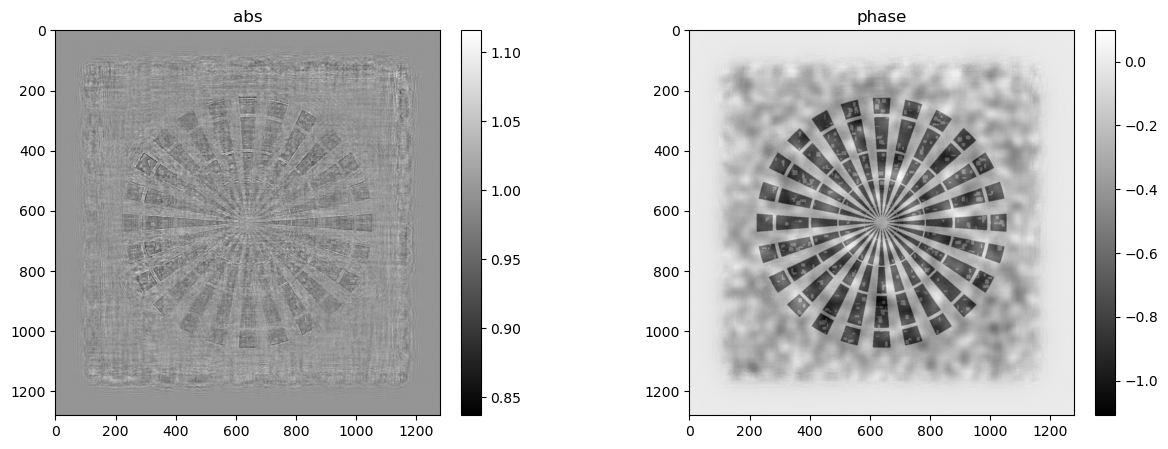

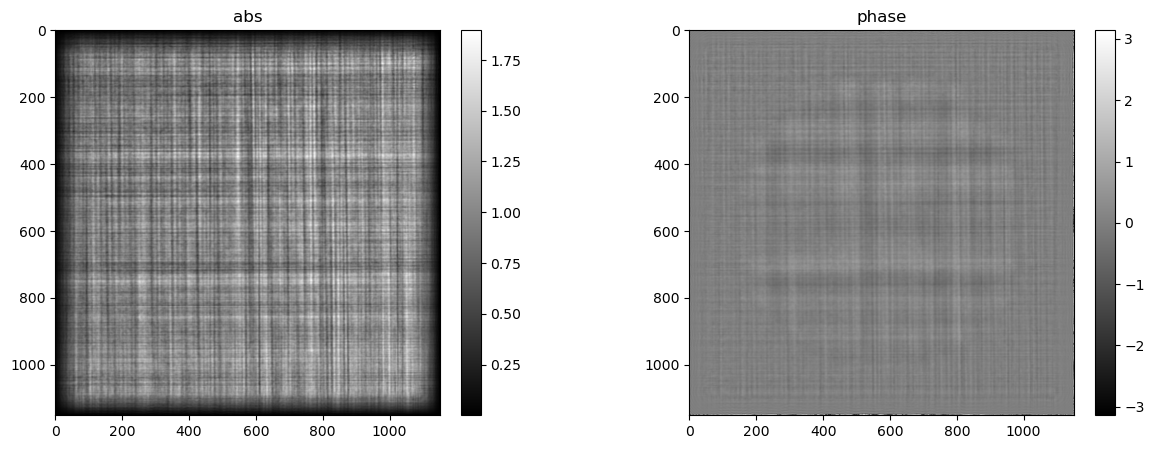

[]

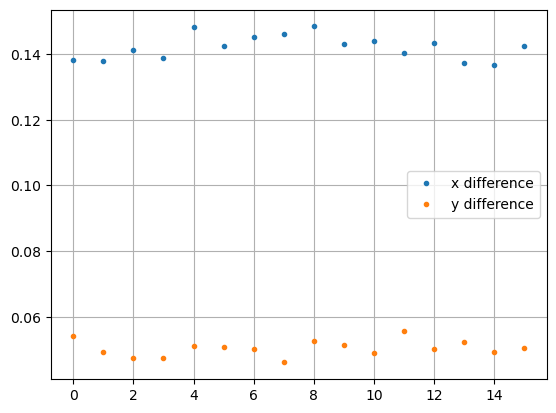

In [10]:


# parameters
pars = {"niter": 100, "err_step": 1, "vis_step": -1}
pars["rho"] = [1, 2, 0.1]
pars["method"] = "BH-CG"
pars["flg"] = f"{pars['method']}_{pars['rho'][0]}_{pars['rho'][1]}_{pars['rho'][2]}"

# variables
vars = {}
vars["psi"] = cp.array(psi_init).copy()
vars["q"] = cp.array(q_init).copy()
vars["ri"] = np.floor(pos_init).astype("int32")
vars["r"] = np.array(pos_init - np.floor(pos_init).astype("int32")).astype("float32")
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])
# reconstruction
vars = cl_rec.BH(data, vars, pars)

# results
erra = vars["table"]["err"].values
plt.plot(erra, label=f"{pars['flg']}")
plt.yscale("log")
plt.grid()
mshow_polar(vars["psi"])
mshow_polar(vars["q"])
pos_rec = vars["ri"] + vars["r"]
plt.plot((pos[:, 1] - pos_rec[:, 1]), ".", label="x difference")
plt.plot((pos[:, 0] - pos_rec[:, 0]), ".", label="y difference")
plt.legend()
plt.grid()
plt.plot()